In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Conv1D, LSTM, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

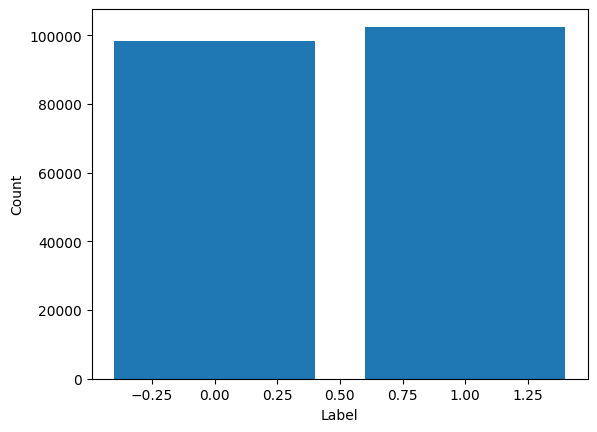

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/train.tsv', sep='\t')
label_counts = df['label'].value_counts()
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


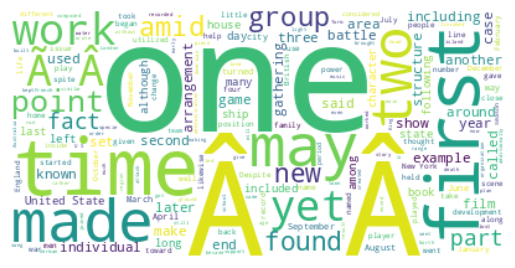

In [ ]:
from wordcloud import WordCloud
text = ' '.join(df['text'].tolist())
wordcloud = WordCloud(background_color='white').generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


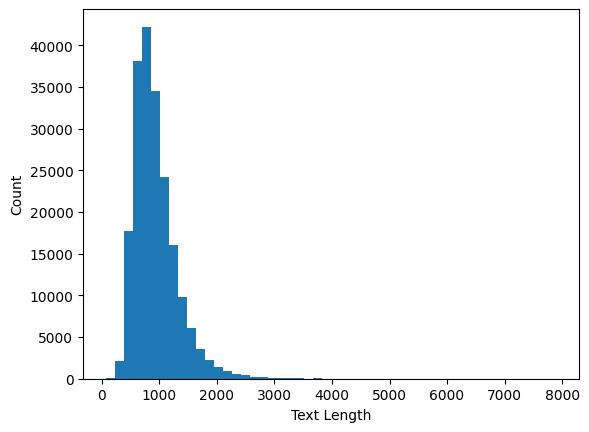

In [ ]:
text_lengths = df['text'].apply(len)
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

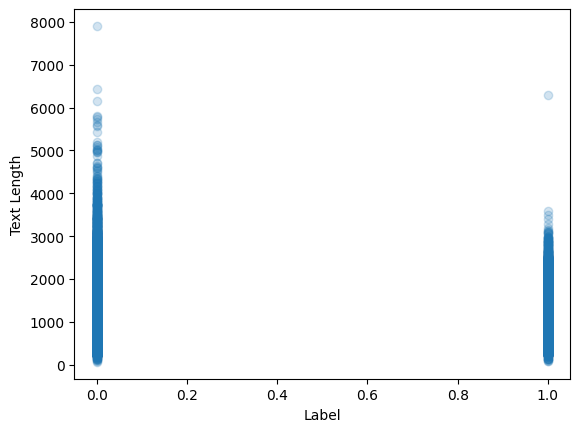

In [ ]:
df["text_length"] = text_lengths
plt.scatter(df['label'], df['text_length'], alpha=0.2)
plt.xlabel('Label')
plt.ylabel('Text Length')
plt.show()

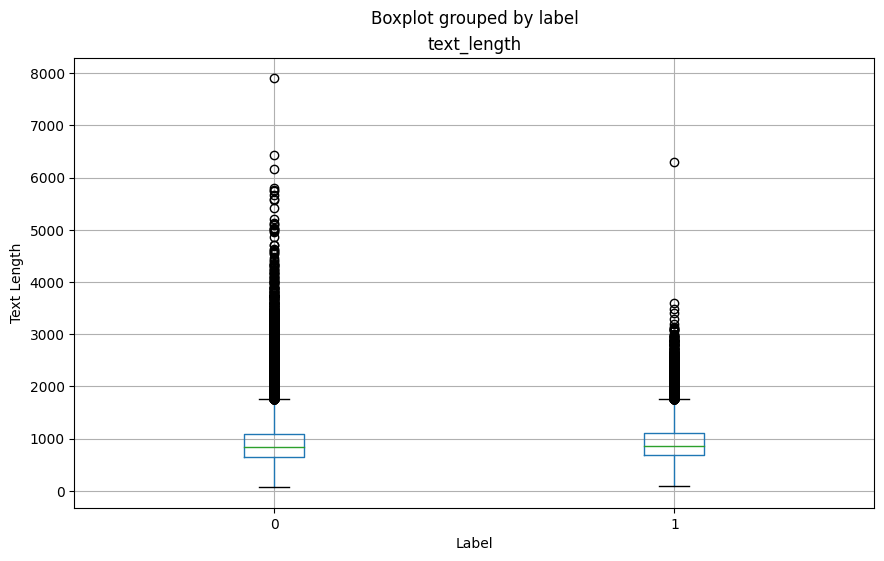

In [ ]:
df.boxplot("text_length", by='label', figsize=(10, 6))
plt.xlabel('Label')
plt.ylabel('Text Length')
plt.show()

In [ ]:
class TextDataset:
    def __init__(self, dataset_file='train.tsv'):
        self.dataset_file = dataset_file
        self.df = pd.read_csv(dataset_file, sep='\t')
        self.tokenizer = None
        self.max_sequence_length = None

    def prepare_data(self, max_sequence_length=100, num_words=10000, test_size=0.2, validation_size=0.2):
        lemmatizer = WordNetLemmatizer()
        self.df['text'] = self.df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w.lower()) for w in word_tokenize(x)]))
        self.tokenizer = Tokenizer(num_words=num_words, lower=True)
        self.tokenizer.fit_on_texts(self.df['text'])
        self.max_sequence_length = max_sequence_length
        sequences = self.tokenizer.texts_to_sequences(self.df['text'])
        sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

        labels = np.array(self.df['label'])
        indices = np.arange(len(labels))
        np.random.shuffle(indices)
        sequences = sequences[indices]
        labels = labels[indices]
        num_test = int(len(labels) * test_size)
        num_validation = int(len(labels) * validation_size)
        num_train = len(labels) - num_validation - num_test
        self.x_train = sequences[:num_train]
        self.y_train = labels[:num_train]
        self.x_val = sequences[num_train:num_train+num_validation]
        self.y_val = labels[num_train:num_train+num_validation]
        self.x_test = sequences[-num_test:]
        self.y_test = labels[-num_test:]

    def create_model(self, embedding_dim=50, num_filters=64, filter_size=3, dropout_rate=0.5, lstm_units=64):
        model = Sequential()
        model.add(Embedding(input_dim=self.tokenizer.num_words, output_dim=embedding_dim, input_length=self.max_sequence_length))
        model.add(Conv1D(num_filters, filter_size, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(LSTM(lstm_units))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model


In [ ]:
text_dataset = TextDataset('/content/drive/MyDrive/train.tsv')

In [ ]:
text_dataset.prepare_data()

In [ ]:
model = text_dataset.create_model()


In [ ]:
history = model.fit(text_dataset.x_train, text_dataset.y_train, epochs=10, batch_size=32, validation_data=(text_dataset.x_val, text_dataset.y_val))

Epoch 1/10
3765/3765 [==============================] - 95s 22ms/step - loss: 0.0604 - accuracy: 0.9759 - val_loss: 0.0162 - val_accuracy: 0.9943
Epoch 2/10
3765/3765 [==============================] - 36s 10ms/step - loss: 0.0145 - accuracy: 0.9956 - val_loss: 0.0180 - val_accuracy: 0.9939
Epoch 3/10
3765/3765 [==============================] - 38s 10ms/step - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.0152 - val_accuracy: 0.9955
Epoch 4/10
3765/3765 [==============================] - 34s 9ms/step - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0312 - val_accuracy: 0.9910
Epoch 5/10
3765/3765 [==============================] - 36s 10ms/step - loss: 0.0057 - accuracy: 0.9981 - val_loss: 0.0225 - val_accuracy: 0.9919
Epoch 6/10
3765/3765 [==============================] - 33s 9ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0153 - val_accuracy: 0.9958
Epoch 7/10
3765/3765 [==============================] - 35s 9ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0167 - va

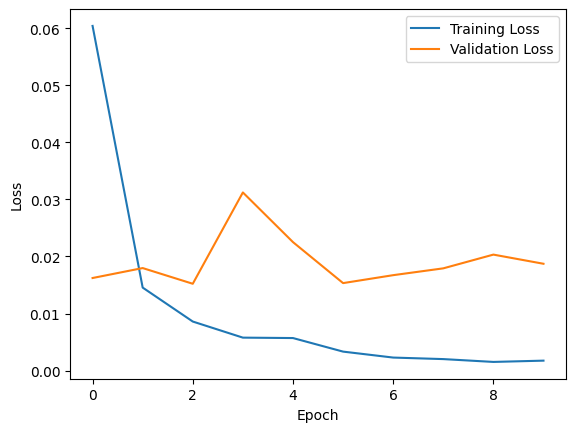

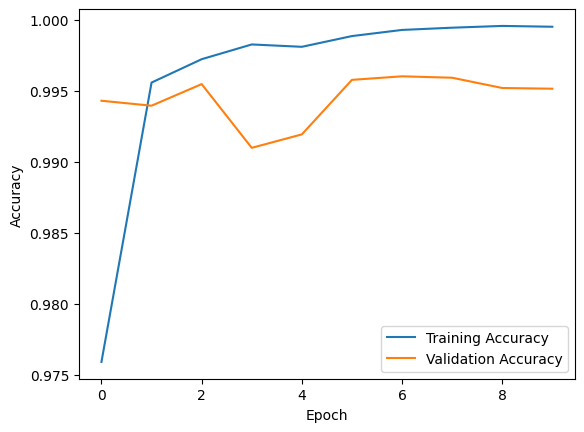

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model.evaluate(text_dataset.x_test, text_dataset.y_test)

1255/1255 [==============================] - 5s 4ms/step - loss: 0.0199 - accuracy: 0.9950


[0.019908316433429718, 0.9950190782546997]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras.models import Model


In [ ]:


def create_model_1(self, embedding_dim=50, num_filters=64, filter_size=3, dropout_rate=0.5, lstm_units=64):
          
    embedding_dim = 50
    num_filters = 32
    filter_size = 3
    dropout_rate = 0.2
    lstm_units = 64
    num_heads = 6
    dff = 512
    num_layers = 2


    inputs = Input(shape=(self.max_sequence_length,), name='input_layer')
    embedding_layer = Embedding(input_dim=self.tokenizer.num_words, output_dim=embedding_dim, name='embedding_layer')(inputs)

    encoder_output = embedding_layer
    for i in range(num_layers):
        attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(encoder_output, encoder_output)
        attention_output = Dropout(dropout_rate)(attention_output)
        attention_output = LayerNormalization(epsilon=1e-6)(encoder_output + attention_output)
        
        feedforward_output = Dense(dff, activation='relu')(attention_output)
        feedforward_output = Dense(embedding_dim)(feedforward_output)
        feedforward_output = Dropout(dropout_rate)(feedforward_output)
        feedforward_output = LayerNormalization(epsilon=1e-6)(attention_output + feedforward_output)
        encoder_output = feedforward_output
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(tf.keras.layers.Reshape((-1,))(encoder_output))
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
text_dataset.create_model = create_model_1

In [ ]:
model = text_dataset.create_model(text_dataset)

In [ ]:
history = model.fit(text_dataset.x_train, text_dataset.y_train, epochs=10, batch_size=32, validation_data=(text_dataset.x_val, text_dataset.y_val))

Epoch 1/10
3765/3765 [==============================] - 102s 25ms/step - loss: 0.2046 - accuracy: 0.8710 - val_loss: 0.0199 - val_accuracy: 0.9944
Epoch 2/10
3765/3765 [==============================] - 66s 18ms/step - loss: 0.0128 - accuracy: 0.9961 - val_loss: 0.0188 - val_accuracy: 0.9927
Epoch 3/10
3765/3765 [==============================] - 67s 18ms/step - loss: 0.0061 - accuracy: 0.9982 - val_loss: 0.0153 - val_accuracy: 0.9955
Epoch 4/10
3765/3765 [==============================] - 65s 17ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0214 - val_accuracy: 0.9955
Epoch 5/10
3765/3765 [==============================] - 68s 18ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0262 - val_accuracy: 0.9958
Epoch 6/10
3765/3765 [==============================] - 67s 18ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0238 - val_accuracy: 0.9959
Epoch 7/10
3765/3765 [==============================] - 69s 18ms/step - loss: 0.0017 - accuracy: 0.9995 - val_loss: 0.0495 

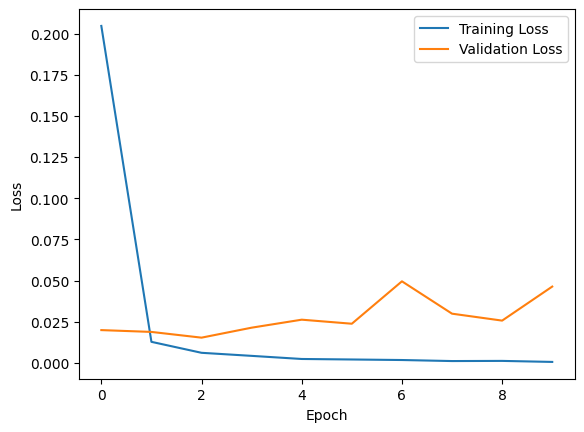

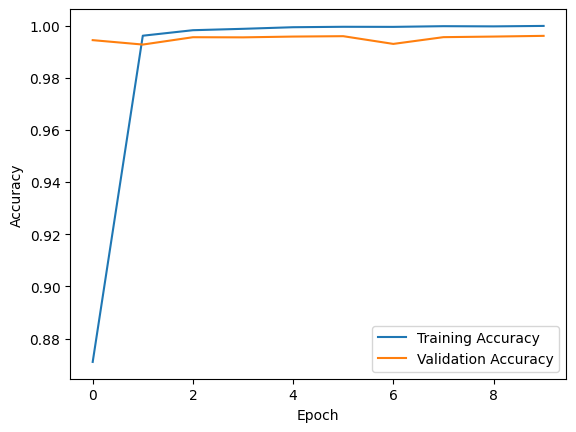

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

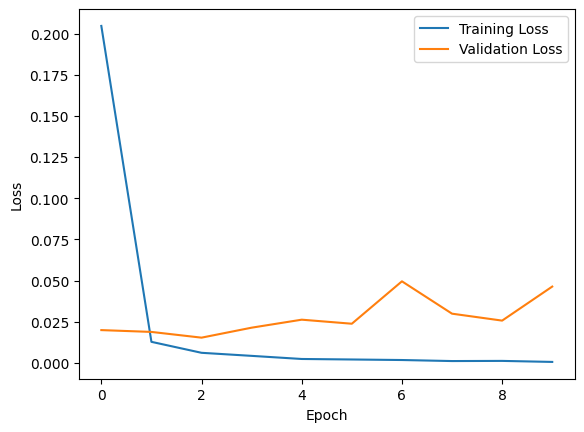

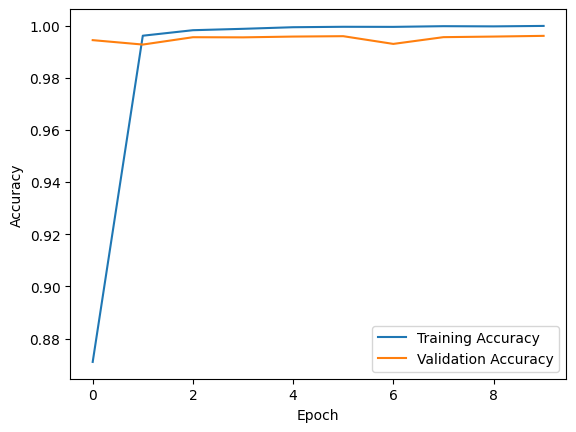

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
